In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams

plt.style.use('ggplot')
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

From the EDA notebook, we found that zipcode 19122 was one of the top 5 zipcodes. We are going to forecast future home values in zipcode 19122 in this notebook.

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
df = pd.read_csv('zillow_data.csv')
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,329121.0,334059.0,338019.0,346657.0,354457.0,361917.0,369769.0,376112.0,381673.0,386586.0,394154.0,402687.0,412006.0,420541.0,429242.0,436291.0,442139.0,447655.0,452725.0,457455.0,461020.0,465658.0,469811.0,475268.0,478912.0,482464.0,484481.0,488259.0,493127.0,499165.0,503717.0,507932.0,511068.0,514280.0,518252.0,522487.0,527352.0,531284.0,535317.0,539349.0,549450.0,567133.0,588505.0,605851.0,613242.0,617110.0,619549.0,625388.0,631255.0,636089.0,639742.0,643306.0,647193.0,652314.0,659961.0,669842.0,683972.0,696806.0,708743.0,716797.0,728843.0,739511.0,759399.0,771571.0,785979.0,795559.0,805064.0,814587.0,817033.0,832764.0,850933.0,876511.0,901911.0,921178.0,927869.0,922251.0,924475.0,931610.0,934145.0,909286.0,874103.0,840213.0,841253.0,864029.0,878088.0,880955.0,875206.0,881249.0,884836.0,877242.0,872894.0,865069.0,888219.0,909058.0,932691.0,932638.0,933780.0,929386.0,935242.0,949011.0,950769.0,940471.0,901618.0,887671.0,894583.0,898397.0,891086.0,854973.0,823871.0,7

In [4]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[9:], format='%Y-%m')

In [5]:
df.columns = list(df.columns[:9]) + list(get_datetimes(df))

In [6]:
#Only rows within the top states of the northeast US
df = df[df['State'].isin(['NY', 'PA', 'NJ', 'MA', 'CT'])]
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,2000-06-30 00:00:00,2000-07-31 00:00:00,2000-08-31 00:00:00,2000-09-30 00:00:00,2000-10-31 00:00:00,2000-11-30 00:00:00,2000-12-31 00:00:00,2001-01-31 00:00:00,2001-02-28 00:00:00,2001-03-31 00:00:00,2001-04-30 00:00:00,2001-05-31 00:00:00,2001-06-30 00:00:00,2001-07-31 00:00:00,2001-08-31 00:00:00,2001-09-30 00:00:00,2001-10-31 00:00:00,2001-11-30 00:00:00,2001-12-31 00:00:00,2002-01-31 00:00:00,2002-02-28 00:00:00,2002-03-31 00:00:00,2002-04-30 00:00:00,2002-05-31 00:00:00,2002-06-30 00:00:00,2002-07-31 00:00:00,2002-08-31 00:00:00,2002-09-30 00:00:00,2002-10-31 00:00:00,2002-11-30 00:00:00,2002-12-31 00:00:00,2003-01-31 00:00:00,2003-02-28 00:00:00,2003-03-31 00:00:00,2003-04-30 00:00:00,2003-05-31 00:00:00,2003-06-30 00:00:00,2003-07-31 00:00:00,2003-08-31 00:00:00,2003-09-30 00:00:00,2003-10-31 00:00:00,2003-11-30 00:00:00,2003-12-31 00:00:00,2004-01-31 00:00:00,2004-02-29 00:00:00,2004-03-31 00:00:00,2004-04-30 00:00:00,2004-05-31 00:00:00,2004-06-30 00:00:00,2004-07-31 00:00:00,2004-08-31 00:00:00,2004-09-30 00:00:00,2004-10-31 00:00:00,2004-11-30 00:00:00,2004-12-31 00:00:00,2005-01-31 00:00:00,2005-02-28 00:00:00,2005-03-31 00:00:00,2005-04-30 00:00:00,2005-05-31 00:00:00,2005-06-30 00:00:00,2005-07-31 00:00:00,2005-08-31 00:00:00,2005-09-30 00:00:00,2005-10-31 00:00:00,2005-11-30 00:00:00,2005-12-31 00:00:00,2006-01-31 00:00:00,2006-02-28 00:00:00,2006-03-31 00:00:00,2006-04-30 00:00:00,2006-05-31 00:00:00,2006-06-30 00:00:00,2006-07-31 00:00:00,2006-08-31 00:00:00,2006-09-30 00:00:00,2006-10-31 00:00:00,2006-11-30 00:00:00,2006-12-31 00:00:00,2007-01-31 00:00:00,2007-02-28 00:00:00,2007-03-31 00:00:00,2007-04-30 00:00:00,2007-05-31 00:00:00,2007-06-30 00:00:00,2007-07-31 00:00:00,2007-08-31 00:00:00,2007-09-30 00:00:00,2007-10-31 00:00:00,2007-11-30 00:00:00,2007-12-31 00:00:00,2008-01-31 00:00:00,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,2008-09-30 00:00:00,2008-10-31 00:00:00,2008-11-30 00:00:00,2008-12-31 00:00:00,2009-01-31 00:00:00,2009-02-28 00:00:00,2009-03-31 00:00:00,2009-04-30 00:00:00,2009-05-31 00:00:00,2009-06-30 00:00:00,2009-07-31 00:00:00,2009-08-31 00:00:00,2009-09-30 00:00:00,2009-10-31 00:00:00,2009-11-30 00:00:00,2009-12-31 00:00:00,2010-01-31 00:00:00,2010-02-28 00:00:00,2010-03-31 00:00:00,2010-04-30 00:00:00,2010-05-31 00:00:00,2010-06-30 00:00:00,2010-07-31 00:00:00,2010-08-31 00:00:00,2010-09-30 00:00:00,2010-10-31 00:00:00,2010-11-30 00:00:00,2010-12-31 00:00:00,2011-01-31 00:00:00,2011-02-28 00:00:00,2011-03-31 00:00:00,2011-04-30 00:00:00,2011-05-31 00:00:00,2011-06-30 00:00:00,2011-07-31 00:00:00,2011-08-31 00:00:00,2011-09-30 00:00:00,2011-10-31 00:00:00,2011-11-30 00:00:00,2011-12-31 00:00:00,2012-01-31 00:00:00,2012-02-29 00:00:00,2012-03-31 00:00:00,2012-04-30 00:00:00,2012-05-31 00:00:00,2012-06-30 00:00:00,2012-07-31 00:00:00,2012-08-31 00:00:00,2012-09-30 00:00:00,2012-10-31 00:00:00,2012-11-30 00:00:00,2012-12-31 00:00:00,2013-01-31 00:00:00,2013-02-28 00:00:00,2013-03-31 00:00:00,2013-04-30 00:00:00,2013-05-31 00:00:00,2013-06-30 00:00:00,2013-07-31 00:00:00,2013-08-31 00:00:00,2013-09-30 00:00:00,2013-10-31 00:00:00,2013-11-30 00:00:00,2013-12-31 00:00:00,2014-01-31 00:00:00,2014-02-28 00:00:00,2014-03-31 00:00:00,2014-04-30 00:00:00,2014-05-31 00:00:00,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,2014-09-30 00:00:00,2014-10-31 00:00:00,2014-11-30 00:00:00,2014-12-31 00:00:00,2015-01-31 00:00:00,2015-02-28 00:00:00,2015-03-31 00:00:00,2015-04-30 00:00:00,2015-05-31 00:00:00,2015-06-30 00:00:00,2015-07-31 00:00:00,2015-08-31 00:00:00,2015-09-30 00:00:00,2015-10-31 00:00:00,2015-11-30 00:00:00,2015-12-31 00:00:00,2016-01-31 00:00:00,2016-02-29 00:00:00,2016-03-31 00:00:00,2016-04-30 00:00:00,2

In [7]:
#grouping the columns by years and their average price
c = df.columns.tolist()
cols = c[:9] 
cols.append(c[-1]) 
print (cols)

#set to index all NOT date columns
tdf = df.set_index(df.columns.tolist()[:9])
tdf.columns = pd.to_datetime(tdf.columns).to_period('M')

# find the columns in the period 2000-2021
cols = tdf.columns
sel_cols = cols[(cols > '2000-01') & (cols < '2022')]
print (sel_cols)


#change format columns
a = tdf[sel_cols].rename(columns=lambda x: '{:}'.format(x.year, [1]))
print (a.columns)

#groupby by a with new format
mdf = a.groupby(a.columns, axis=1).mean().reset_index()

['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName', Timestamp('2021-08-31 00:00:00')]
PeriodIndex(['2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07',
             '2000-08', '2000-09', '2000-10', '2000-11',
             ...
             '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04',
             '2021-05', '2021-06', '2021-07', '2021-08'],
            dtype='period[M]', length=259, freq='M')
Index(['2000', '2000', '2000', '2000', '2000', '2000', '2000', '2000', '2000',
       '2000',
       ...
       '2020', '2020', '2021', '2021', '2021', '2021', '2021', '2021', '2021',
       '2021'],
      dtype='object', length=259)


In [8]:
mdf['average_annual_return'] = (((mdf['2021']-mdf['2000'])/mdf['2000'])*100)
mdf['rate_year']=mdf['average_annual_return']/21
top_five = mdf.sort_values(by='rate_year', ascending=False).head(5)
top_five

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,average_annual_return,rate_year
2855,58807,16737,2558,Zip,MA,MA,Wareham,Boston-Cambridge-Newton,Plymouth County,36981.818182,46860.750000,58951.166667,73839.583333,81465.333333,91191.083333,98618.500000,90287.416667,90895.416667,81423.500000,81278.916667,81293.000000,84706.583333,109882.416667,136346.750000,1.623931e+05,1.896925e+05,2.189622e+05,2.584022e+05,2.676696e+05,3.246265e+05,366638.625,891.402378,42.447732
92,62027,516,11216,Zip,NY,NY,New York,New York-Newark-Jersey City,Kings County,159543.000000,186038.166667,220661.500000,268010.916667,313416.416667,377583.333333,460031.750000,522687.083333,541119.583333,471203.166667,456315.666667,465404.083333,507982.166667,613773.833333,814626.583333,9.696168e+05,1.058784e+06,1.076584e+06,1.145235e+06,1.144215e+06,1.145505e+06,1152785.125,622.554499,29.645452
708,65789,5379,19122,Zip,PA,PA,Philadelphia,Philadelphia-Camden-Wilmington,Philadelphia County,43344.909091,49257.500000,60191.916667,73493.833333,92622.500000,107774.916667,136895.916667,160958.416667,155417.500000,164019.416667,167015.916667,158536.416667,145589.583333,161409.416667,167096.083333,1.783024e+05,1.789871e+05,2.031756e+05,2.369558e+05,2.594141e+05,2.750910e+05,295731.375,582.274761,27.727370
227,65788,1572,19121,Zip,PA,PA,Philadelphia,Philadelphia-Camden-Wilmington,Philadelphia County,36210.818182,41512.083333,42839.500000,47378.500000,58035.166667,77900.916667,97453.083333,113018.166667,103451.750000,100302.583333,93118.083333,79137.750000,62845.750000,73558.916667,81038.500000,9.014233e+04,9.106808e+04,1.119107e+05,1.495841e+05,1.782407e+05,2.029722e+05,236809.125,553.973417,26.379687
183,62033,1187,11222,Zip,NY,NY,New York,New York-Newark-Jersey City,Kings County,179628.636364,222675.416667,298888.750000,360174.833333,421157.666667,573325.750000,654414.833333,663559.750000,641443.416667,582575.250000,563242.000000,573196.083333,618760.000000,737275.833333,876103.333333,1.011760e+06,1.054034e+06,1.063602e+06,1.078892e+06,1.085332e+06,1.087756e+06,1096991.500,510.699676,24.319032


In [9]:
#getting the list of zipcodes
values = set(top_five['RegionID'])
#getting them in our old dateFrame
df_new = df[df['RegionID'].isin([58807, 62027, 62033, 65788, 65789])]

In [10]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [11]:
df_11216 = df_new[df_new['RegionName']==11216]
df_11222 = df_new[df_new['RegionName']==11222]
df_19121 = df_new[df_new['RegionName']==19121]
df_19122 = df_new[df_new['RegionName']==19122]
df_2558  = df_new[df_new['RegionName']==2558]

In [12]:
df_11216 = melt_data(df_11216)
df_11222= melt_data(df_11222)
df_19121= melt_data(df_19121)
df_19122= melt_data(df_19122)
df_2558= melt_data(df_2558)

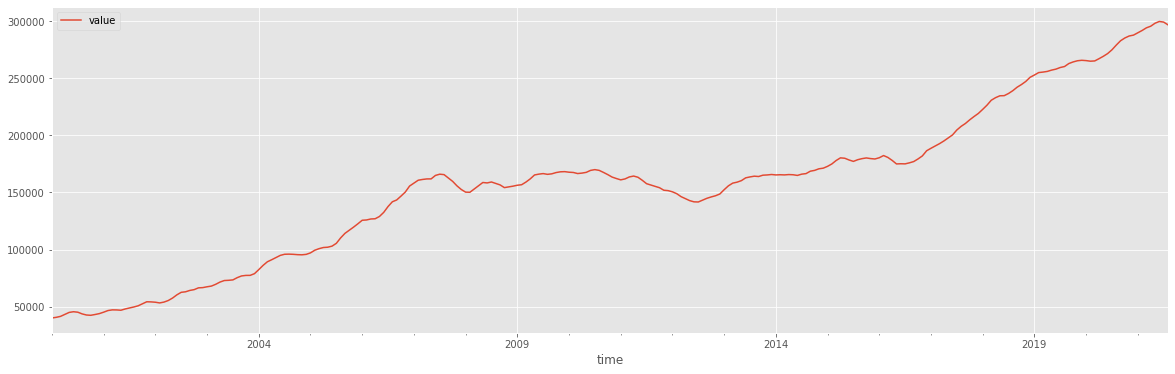

In [13]:
df_19122.plot(figsize=(20,6));

# Baseline Model

In [14]:
naive = df_19122.shift(1)
naive


,value
time,
2000-01-31,NaN
2000-02-29,40085.0
2000-03-31,40648.0
2000-04-30,41501.0
2000-05-31,43180.0
...,...
2021-04-30,294232.0
2021-05-31,295642.0
2021-06-30,298257.0


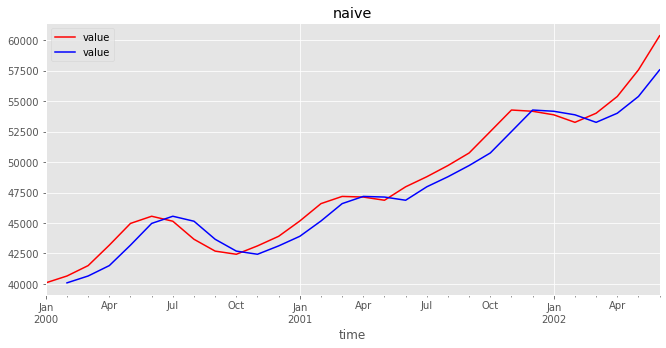

In [15]:
fig, ax = plt.subplots(figsize=(11, 5))

df_19122[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [16]:
dftest = adfuller(naive.dropna())
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.429645
p-value                          0.905030
#Lags Used                      16.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


# Modeling

In [17]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(df_19122)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print('19122')
print(dfoutput)

Results of Dickey-Fuller Test: 

19122
Test Statistic                  -0.527167
p-value                          0.886605
#Lags Used                      16.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


<AxesSubplot:xlabel='time'>

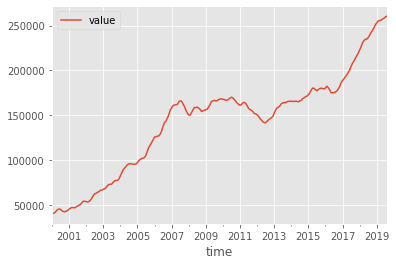

In [18]:
df_19122_train =df_19122[:236]
df_19122_test = df_19122[236:] 
df_19122_train.plot()

# Check Seasonality

We can check for trends, seasonality, and residuals using seasonal_decompose function.


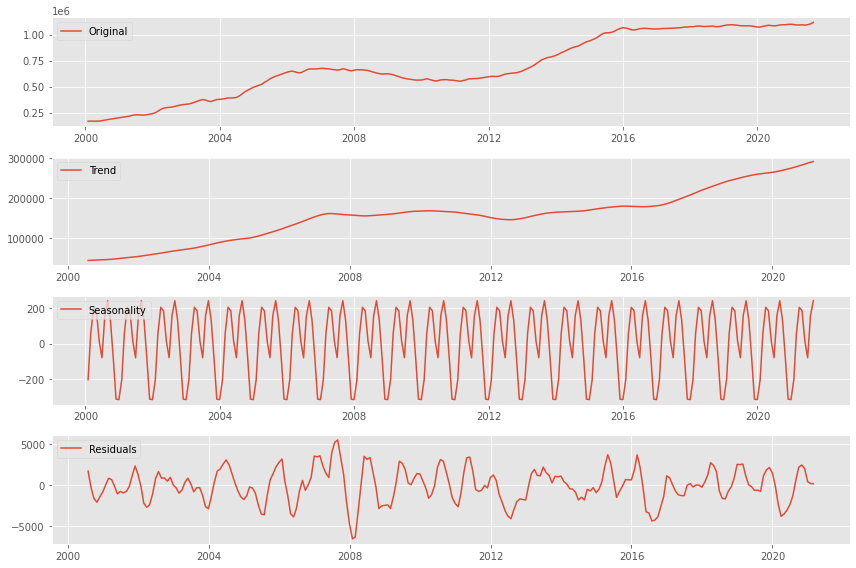

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df_19122)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_11222, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

The model has an upward trend with seasonality as well.

# Rolling Mean

<AxesSubplot:xlabel='time'>

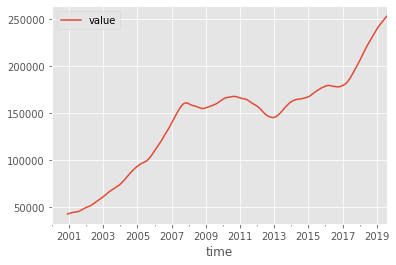

In [20]:
df_19122_train.rolling(12).mean().plot()

# First order difference

<AxesSubplot:xlabel='time'>

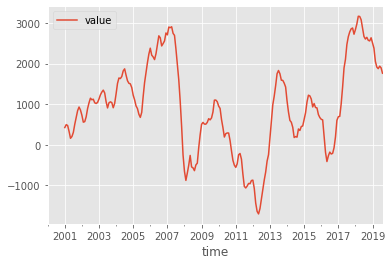

In [21]:
df_19122_train.diff(periods=1).rolling(12).mean().plot()

# Second Order Difference

<AxesSubplot:xlabel='time'>

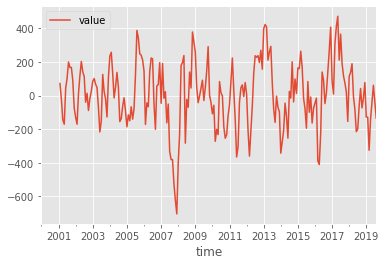

In [22]:
df_19122_train.diff().diff().rolling(12).mean().plot()

# Differencing

In [23]:
diff = df_19122.diff().diff().dropna()

dftest = adfuller(diff)
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.030660e+00
p-value                        1.420597e-07
#Lags Used                     1.400000e+01
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


Taking two difference makes our p-value < 0.05. Let's look at autocorrelation.

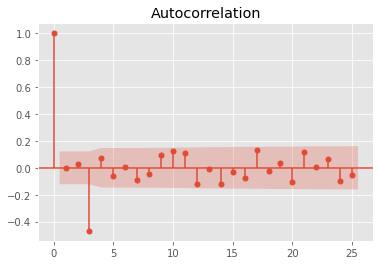

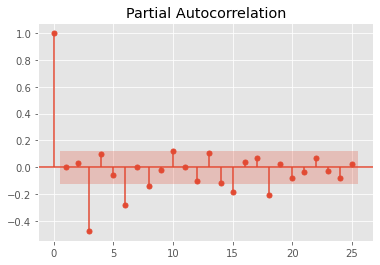

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation Plot
plot_acf(df_19122.diff().diff().dropna());

# Partial Autocorrelation Plot
plot_pacf(df_19122.diff().diff().dropna());

# SARIMAX

In [25]:
# Fit a SARIMAX model on the data set with a first order difference.

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sm = SARIMAX(endog=df_19122_train, order =(0,1,0)).fit()

In [27]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(df_19122_train, sm.predict(), squared=False)
rmse

3246.4013087767075

To get the best hyperparameters for our model, we created a combination of orders and seasonal orders in the range of 0-2, inclusive.

In [28]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [29]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(df_19122,
                          order=comb,
                          seasonal_order=combs,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6974.179626551247
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6502.212039792528
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =6180.005160403285
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5539.6847775767255
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5281.110789814503
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =4947.120010120042
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =5213.09424233143
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =4896.545009154354
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =4642.423170472843
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5426.436539986099
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5389.658960769528
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =5136.8953993593095
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5193.936458341234
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =6290.595354810342
ARIMA (0, 0, 0) x (

ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4272.30421855281
ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =4076.144212447093
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4168.188089287054
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4092.999368092528
ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3861.7631460379644
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4148.64147988888
ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3963.1955921400317
ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3731.3040521853236
ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =4104.017506260698
ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =4099.47268691084
ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =4067.2619508109105
ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3928.448036589244
ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3913.9434118091026
ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3863.7607762982843
ARIMA (0, 1, 1) x

ARIMA (0, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =3984.5503613499422
ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =3937.0388434415663
ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3856.900790735344
ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3849.839588745359
ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3775.5749583330944
ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3779.9109431955617
ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3699.5994965383024
ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3651.5455420333847
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4588.79445925495
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4517.999401202451
ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =4183.321939400683
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4532.703918577967
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4329.852298277479
ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =4001.4292229241682
ARIMA (1, 0, 0

ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =3950.172395647097
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4327.392085762025
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4014.1568342246164
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3781.6734884096604
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4373.20970825684
ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3947.315477338298
ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3675.3938620537474
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4162.1546955013955
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4147.475300003226
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =3951.930719705384
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4073.715694482532
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4016.0721997488436
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3775.7889526404047
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4061.3385239530667
ARIMA (1, 1, 1

ARIMA (1, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =3893.4320369523466
ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4065.969821413628
ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3954.099762858302
ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3724.8159139881964
ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4087.3422201899557
ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3885.1044407907766
ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3620.7112004349847
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =3929.7898979642487
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =3925.9638294327797
ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =3896.20594722409
ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3819.0783237778423
ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3767.297457173766
ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3728.6600100807955
ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3735.4841168885687
ARIMA (1, 2

ARIMA (2, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =3950.7086431378666
ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3811.730235197363
ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3789.150169143125
ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3778.6093208946295
ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3740.8097374822087
ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3668.297471546459
ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3669.941268173219
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4342.289918640301
ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4146.243033733403
ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =3949.1963842004134
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4323.58725879234
ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4015.3311119555133
ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3785.6832828076776
ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4357.655111777567
ARIMA (2, 1, 1)

ARIMA (2, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =3873.0665423386617
ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =4298.681287469888
ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3931.684363550311
ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3717.9405155923714
ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =4316.001689221863
ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3927.6149672380634
ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3744.8833897673176
ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =4082.8287872891515
ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =4068.9896282029754
ARIMA (2, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =3877.9754326391026
ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4040.9624511299326
ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3930.4356206716016
ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3734.3823547889924
ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =4064.331354665542
ARIMA (2, 

In [30]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 2)
pdqs    (2, 2, 2, 12)
aic       3590.957746
Name: 161, dtype: object

From the combination, our SARIMAX model with order=(0,1,2) and seasonal_order=(2, 2, 2, 12) got the lowest aic score.

Now, we can use those hyperparameters for our final model to predict future home values.

In [31]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = SARIMAX(df_19122, 
                                        order=(0, 1, 2), 
                                        seasonal_order=(2, 2, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9758      0.027     36.482      0.000       0.923       1.028
ma.L2          0.9178      0.039     23.792      0.000       0.842       0.993
ar.S.L12       0.0686      0.049      1.387      0.165      -0.028       0.165
ar.S.L24       0.0692      0.036      1.943      0.052      -0.001       0.139
ma.S.L12      -1.6585      0.101    -16.342      0.000      -1.857      -1.460
ma.S.L24       0.6820      0.063     10.829      0.000       0.559       0.805
sigma2      1.333e+06   1.81e+05      7.373      0.000    9.79e+05    1.69e+06


Next, we ran model diagnostics to ensure that none of the assumptions made by the model have been violated.


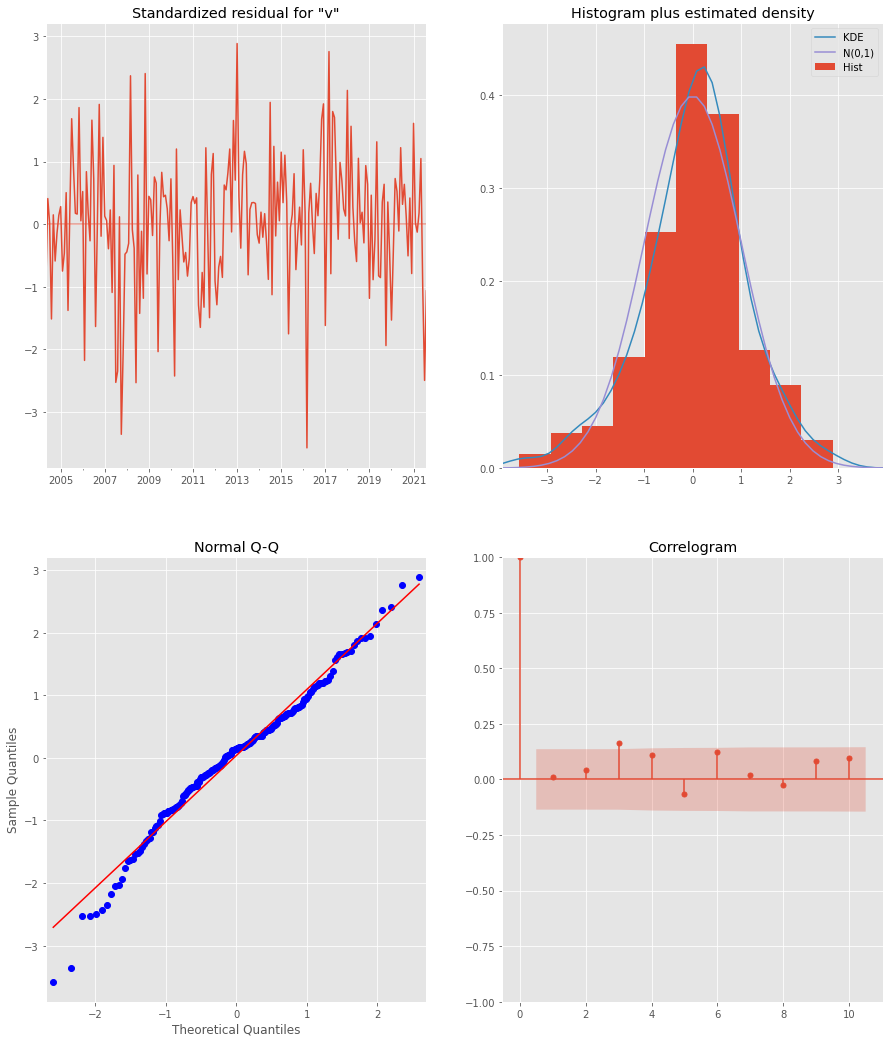

In [32]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

The first plot shows that the some residuals are normally distributed. The top right plot shows that the data seems normally distributed. The bottom left plot shows that the residuals follow the linear trend from a standard normal distribution. The bottom right plot shows that the autocorrelation.

# Validating the Model

We will now validate the model by comparing predicted values to real values.

Starting from January 2019

In [33]:
# Get predictions starting from 01-31-2019 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=False)
pred_conf = pred.conf_int()

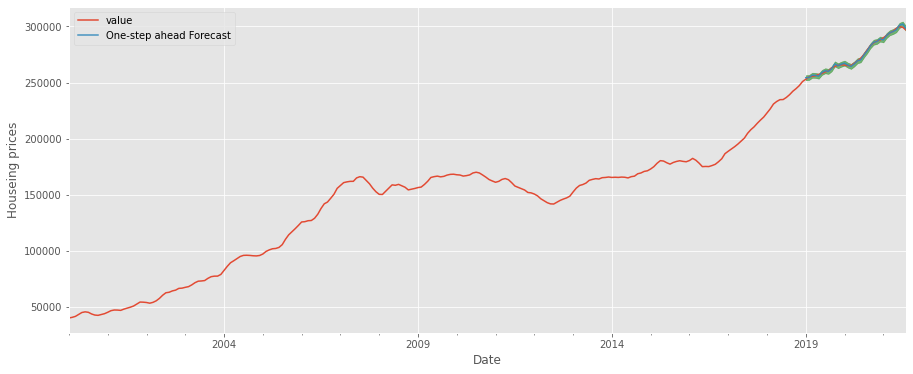

In [34]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_19122.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Houseing prices')
plt.legend()

plt.show()

In [35]:
# Get the real and predicted values
df19122_forecasted = pred.predicted_mean
df19122_truth = df_19122['value']['2019-01-31':]

# Compute the mean square error
mse = ((df19122_forecasted - df19122_truth) ** 2).mean()
rmse =np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 1104.53


# Dynamic Forecasting

In [36]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

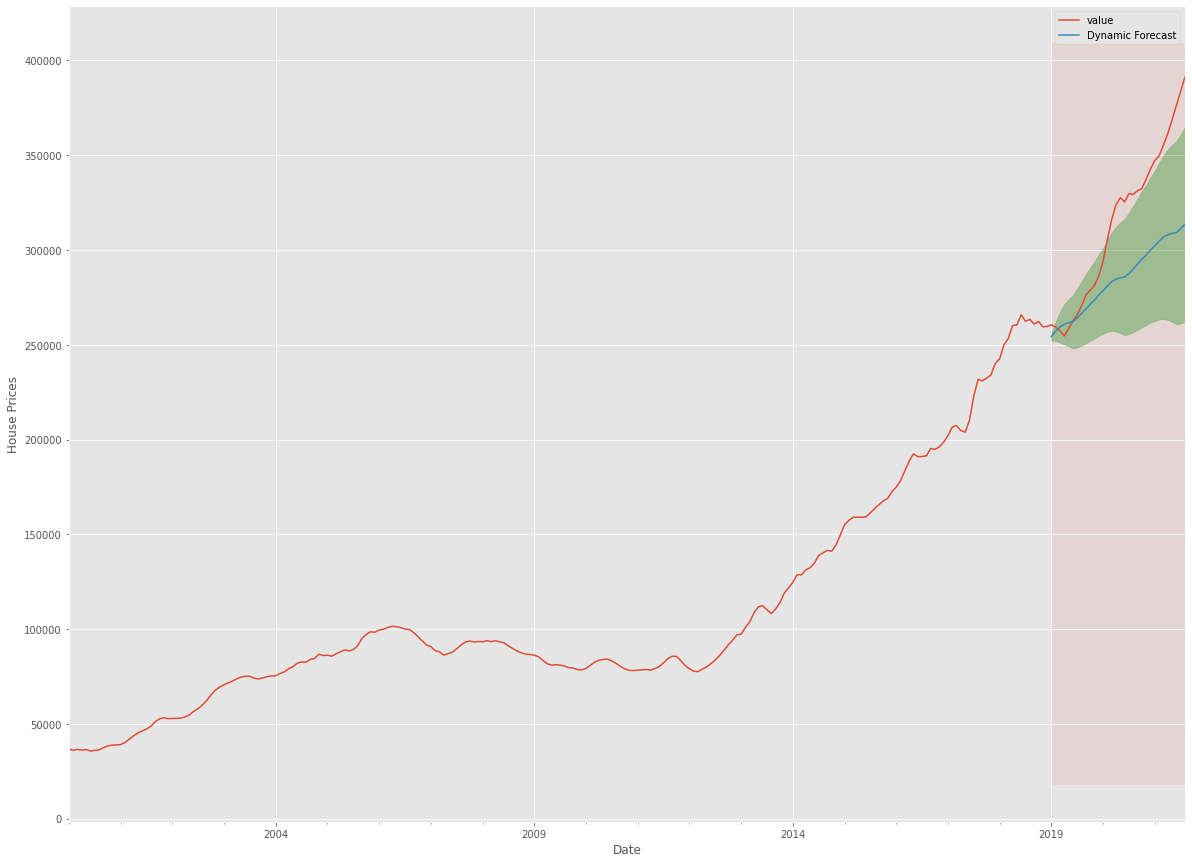

In [37]:
# Plot the dynamic forecast with confidence intervals.

ax = df_2558.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2019-01-31'), df19122_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('House Prices')

plt.legend()
plt.show()

# Producing and Visualizing Forecasts

In [38]:

# Get forecast 100 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

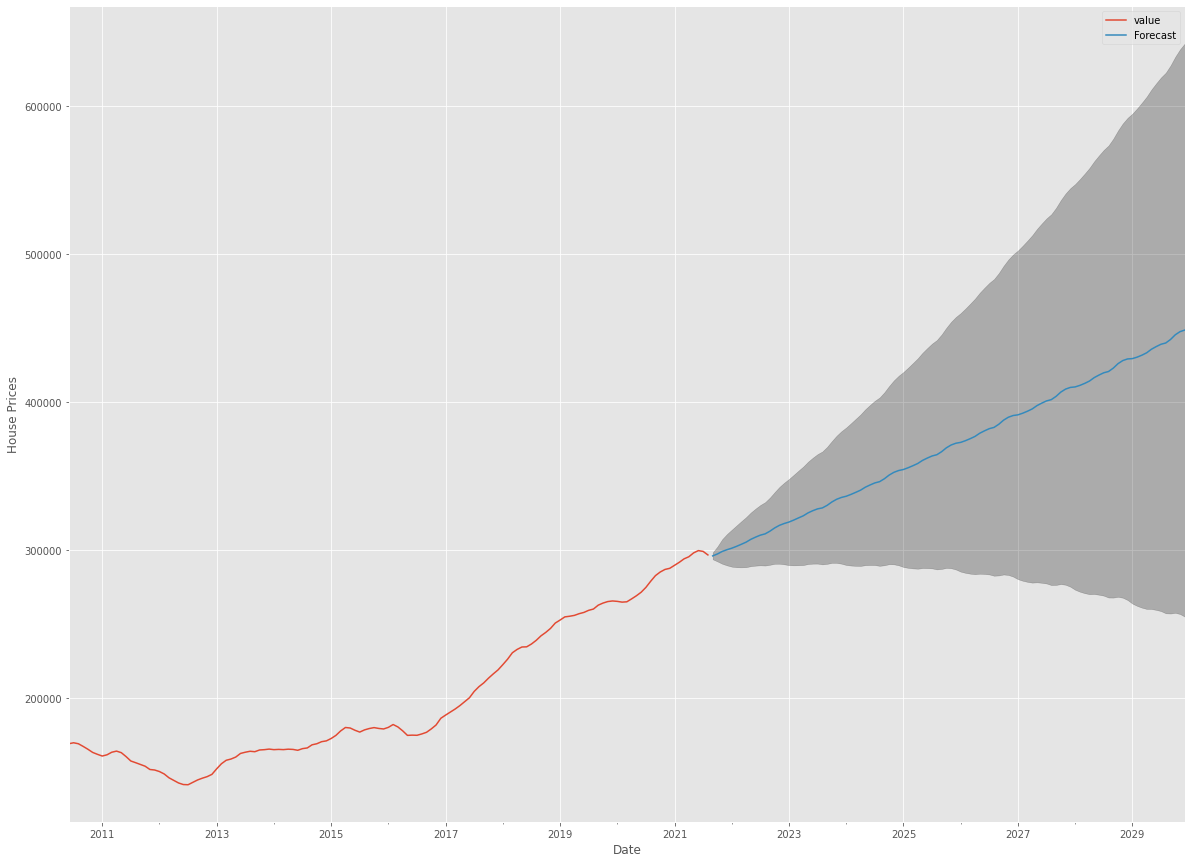

In [39]:
# Plot future predictions with confidence intervals
ax = df_19122.iloc[125:].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Prices')

plt.legend()
plt.show()